# Analysis and Visualisation 
Only those not in the comparison between 

## Load preprocessed data

In [1]:
#!pip install datasets
#!pip install gensim

In [29]:
# Will not run as we couldn't upload tldr_cleaned_sample due to size
from datasets import load_from_disk

tldr_cleaned_sample = load_from_disk('../../tldr_cleaned_sample')


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from wordcloud import WordCloud
from matplotlib import cm
from matplotlib.colors import Normalize

## First overview

In [31]:
# preprocessed from PreprocessingEMI.ipynb, not in git because it is too big 
tldr_cleaned_sample

Dataset({
    features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary', 'clean', 'avg_vec', 'evidence_sim', 'intuition_sim', 'length_bin', 'z_evidence', 'z_intuition', 'emi', 'clean_short', 'avg_vec_short', 'evidence_sim_short', 'intuition_sim_short', 'length_bin_short', 'z_evidence_short', 'z_intuition_short', 'emi_short'],
    num_rows: 615392
})

In [32]:
# pd df easier for visualisation 
tldr_df = tldr_cleaned_sample.to_pandas()

### Predefine colors <3

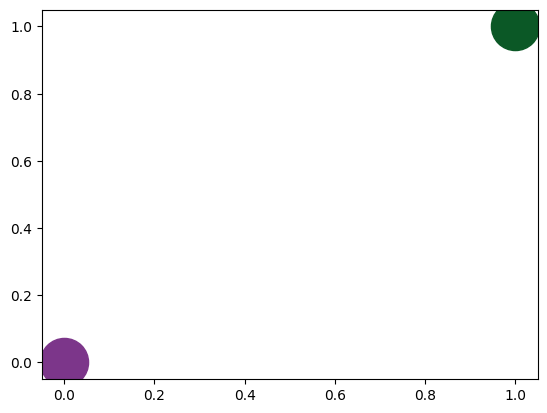

In [33]:
colormap = plt.get_cmap('PRGn')  
plt.scatter(x = [0], y = [0], s =1200, color= colormap(30), label = 'intuition')
plt.scatter(x = [1], y = [1], s =1200, color= colormap(245), label = 'evidence')
intColor = colormap(30)
evColor = colormap(245)
baseColor = colormap(45)


## Top x token wordcloud

### Adding word EMI for wordcloud

In [34]:
subreddits = tldr_df['subreddit'].unique()

In [35]:
# evidence and inutition word list from 'Computational analysis of US congressional speeches reveals a shift from evidence to intuition'
evidence_list = [
    "accurate", "exact", "intelligence", "precise", "search", "analyse", "examination",
    "investigate", "procedure", "show", "analysis", "examine", "investigation", "process",
    "statistics", "correct", "expert", "knowledge", "proof", "study", "correction", "explore",
    "lab", "question", "trial", "data", "fact", "learn", "read", "real", "dossier", "find",
    "logic", "reason", "true", "education", "findings", "logical", "research", "truth",
    "evidence", "information", "method", "science", "truthful", "evident", "inquiry",
    "pinpoint", "scientific"
]

intuition_list = [
    "advice", "doubt", "mislead", "suggestion", "belief", "fake", "mistaken", "suspicion",
    "believe", "fake news", "mistrust", "view", "bogus", "feeling", "opinion", "viewpoint",
    "common sense", "genuine", "perspective", "wrong", "deceive", "guess", "phony",
    "deception", "gut", "point of view", "dishonest", "instinct", "propaganda", "dishonesty",
    "intuition", "sense", "distrust", "lie", "suggest"
]


In [36]:
# cosine similarity for map
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    
    if norm_a == 0 or norm_b == 0:
        return 0.0  # Avoid division by zero
    
    return dot_product / (norm_a * norm_b)

In [37]:
# average the vectors per post to calculate similarity to evidence and intuition vectors
def get_avg_vectors(tokens, model):
    
    # Filter tokens that are in the model's vocabulary
    valid_tokens = [token for token in tokens if token in model.wv]
    
    if not valid_tokens:
        return [], [np.zeros(model.vector_size)* len(tokens)] ,np.zeros(model.vector_size)  # Return a zero vector if no valid tokens
    
    # Get vectors for the valid tokens
    word_vectors = np.array([model.wv[token] for token in valid_tokens])
    
    # Compute the average of word vectors
    avg_vector = np.mean(word_vectors, axis=0)
    return valid_tokens, word_vectors, avg_vector

In [38]:
def get_emi_token(word, model, e_vec, i_vec):
    
    # Filter tokens that are in the model's vocabulary
    if not word in model.wv:
        return 0
    
    
    # Get the word vectors for the valid tokens
    word_vec = model.wv[word]
    evidence_sim = np.float32(cosine_similarity(word_vec, e_vec))
    intuition_sim = np.float32(cosine_similarity(word_vec, i_vec))

    emi = evidence_sim - intuition_sim
    
    return emi 

In [39]:
# get evidence and intuition vector 
from gensim.models import Word2Vec
model = Word2Vec.load("../../w2v/word2vec_tldr.model")

valid_evidence, evidence_vectors, evidence_vector = get_avg_vectors(evidence_list, model)
valid_intuition, inuition_vectors, intuition_vector = get_avg_vectors(intuition_list, model)

In [40]:
# get token counting dict and then EMI score for those tokens, but EMI usually averaged so no z standardization with binning for now 
word_stats = {}
word_stats_df = {}

for reddit in subreddits: 

    words = [word for sublist in tldr_df[tldr_df['subreddit'] == reddit]['clean'] for word in sublist]
    word_stats[reddit] = {}
    for word in words:
        if word not in word_stats[reddit]:
            word_stats[reddit][word] = {
                'count': 1,
                'emi': get_emi_token(word, model, evidence_vector, intuition_vector)
            }
        else:
            word_stats[reddit][word]['count'] += 1

    
    word_stats_df[reddit] = pd.DataFrame.from_dict(word_stats[reddit], orient='index').rename_axis('word').reset_index().sort_values('count', ascending=False)



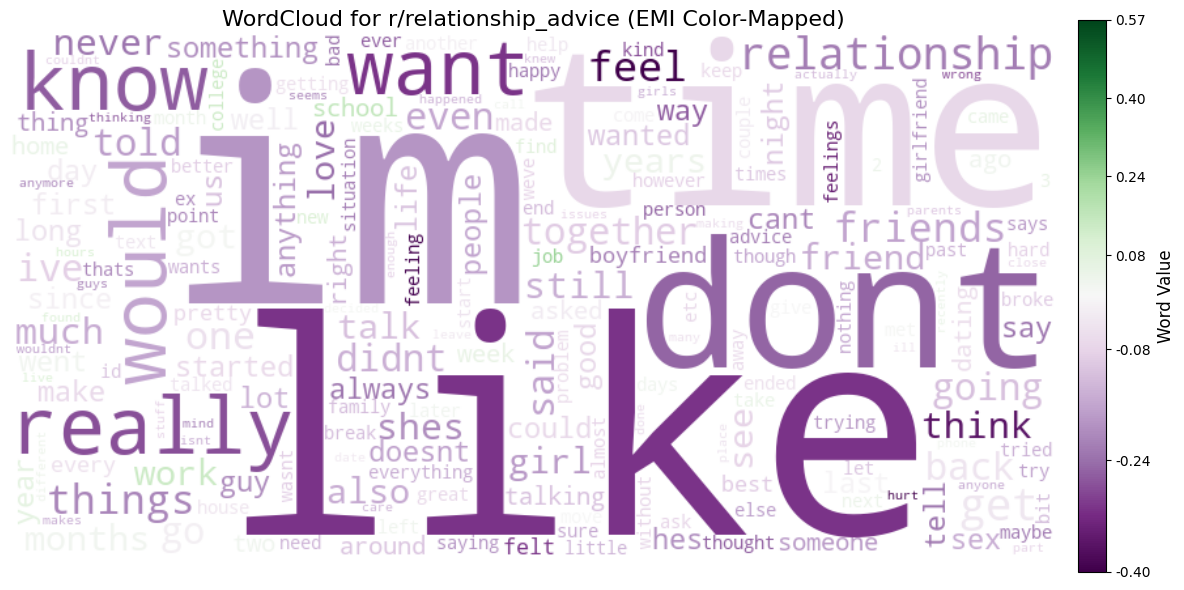

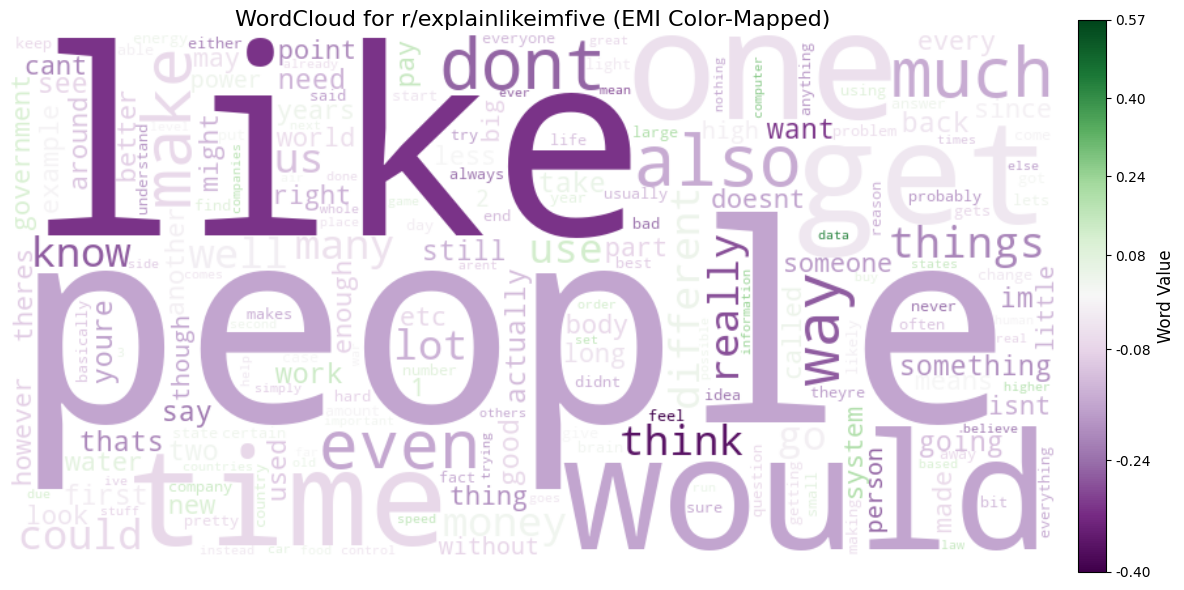

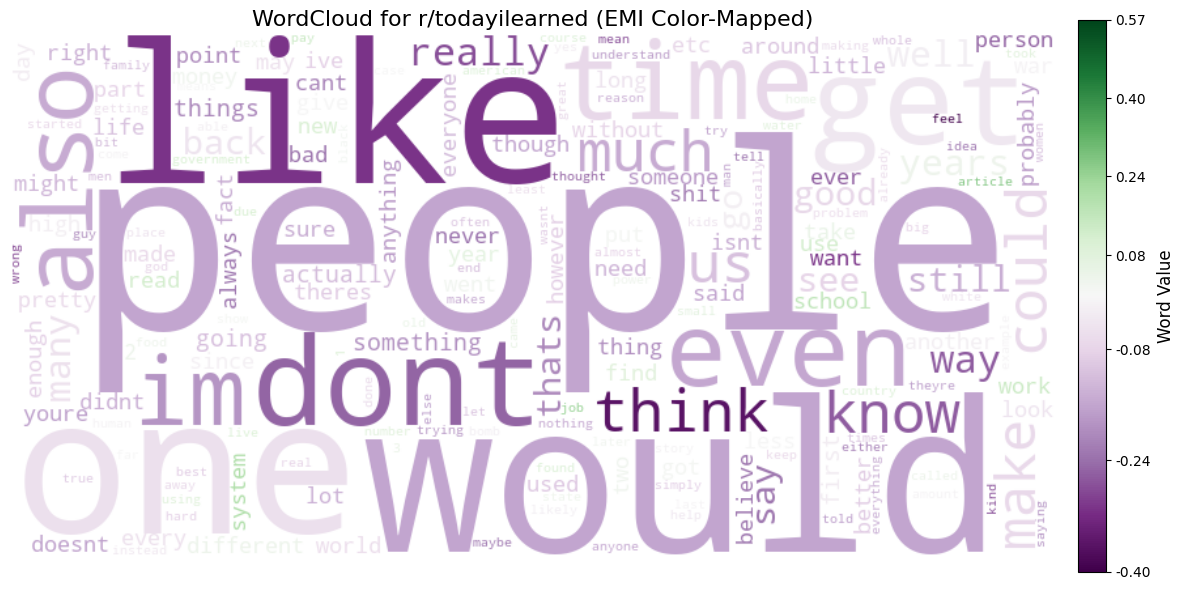

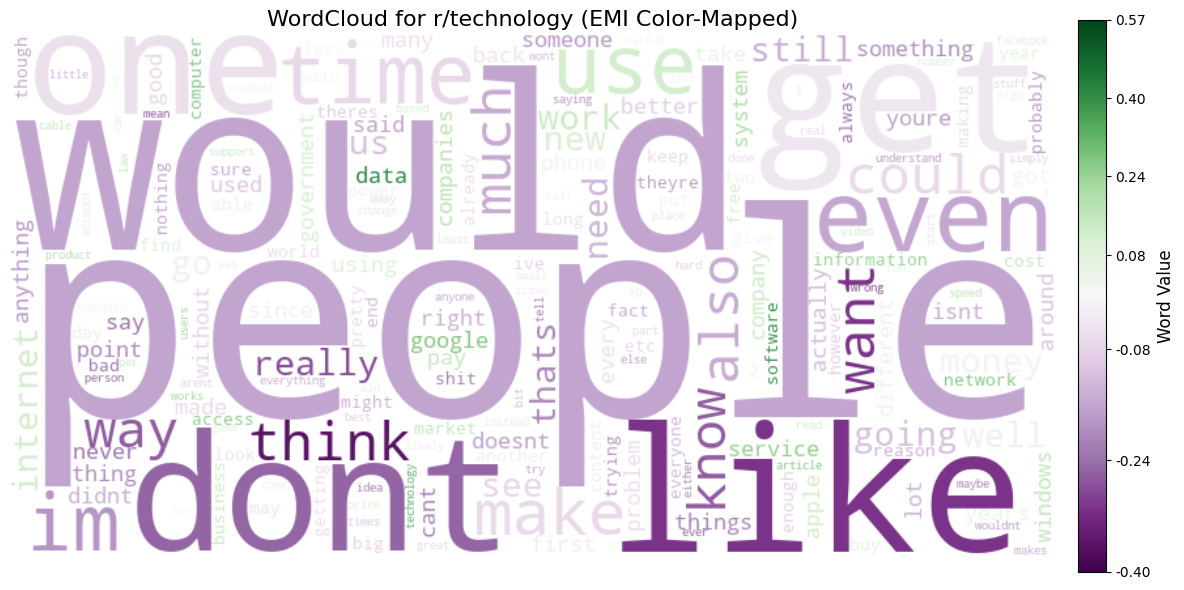

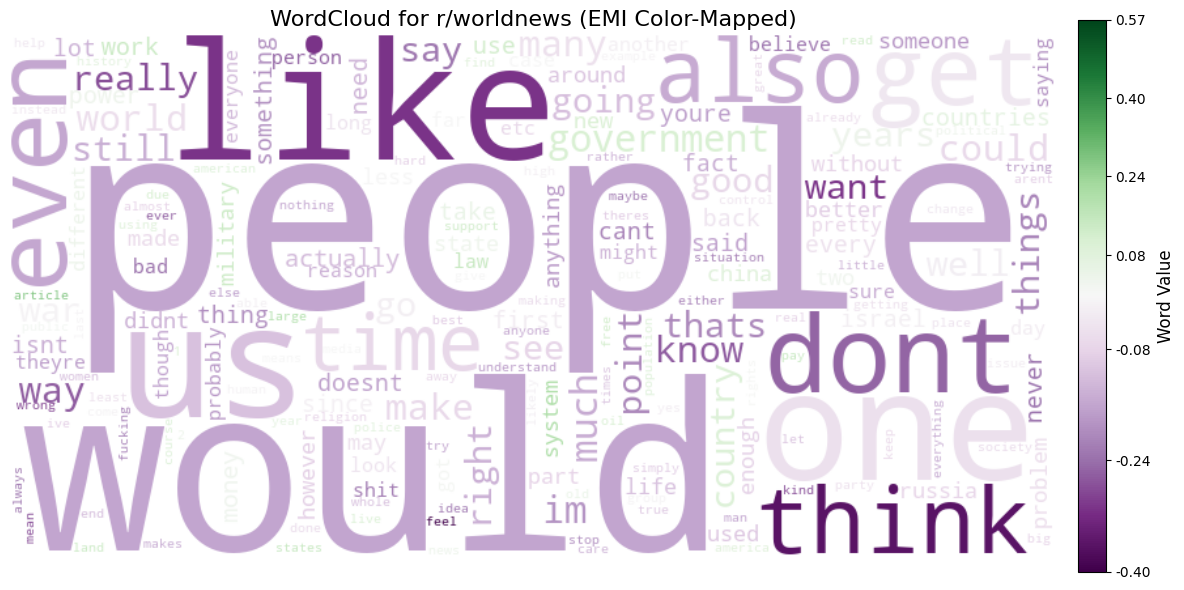

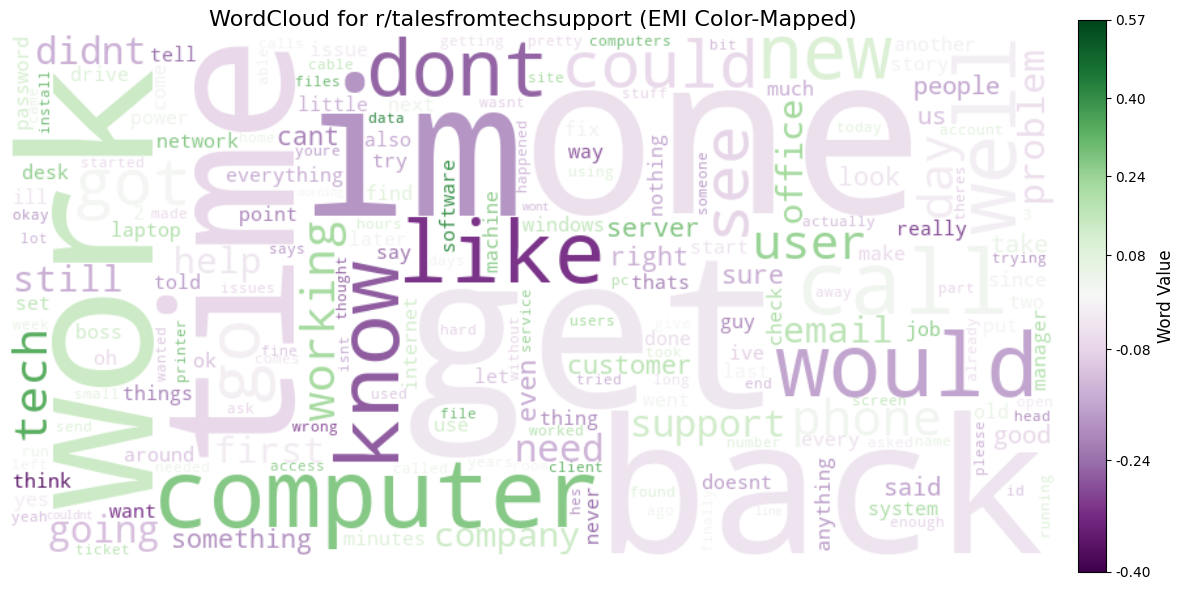

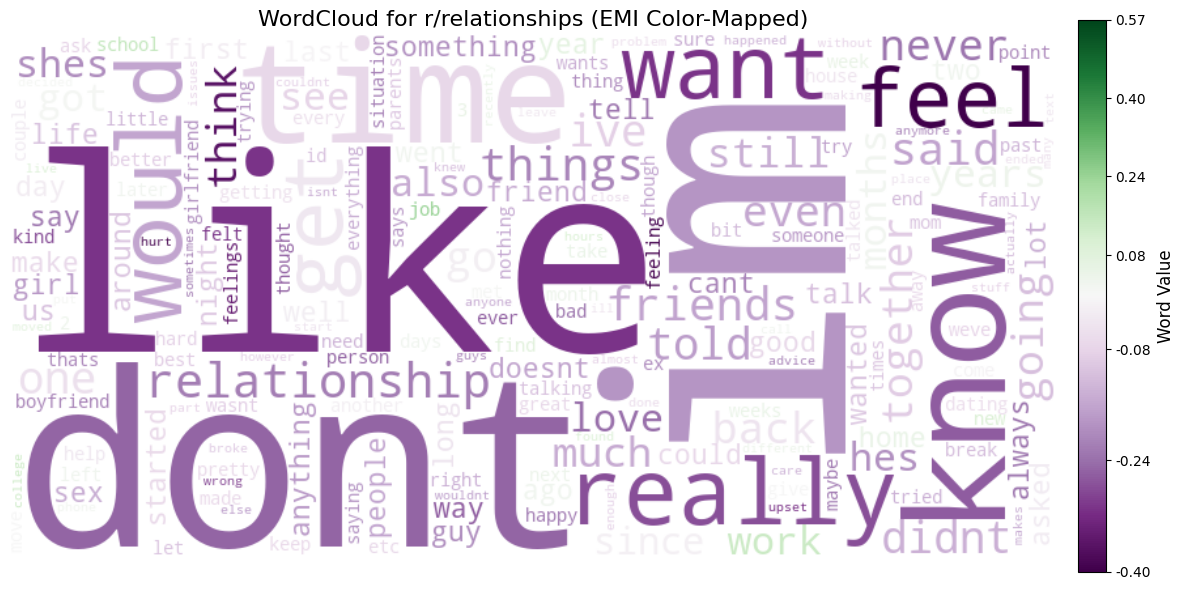

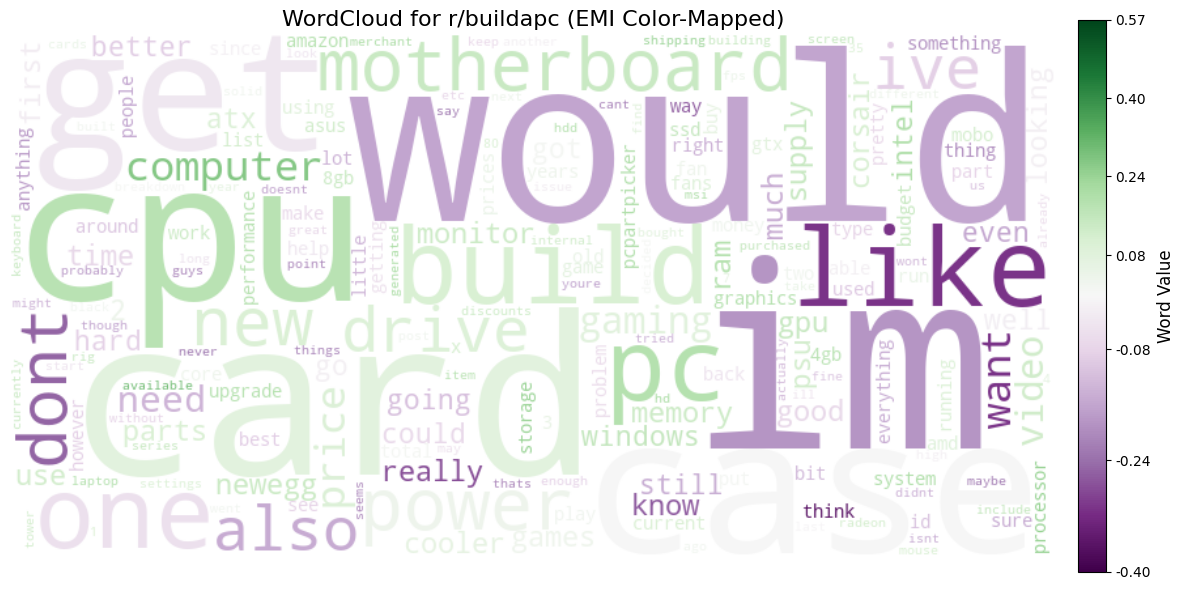

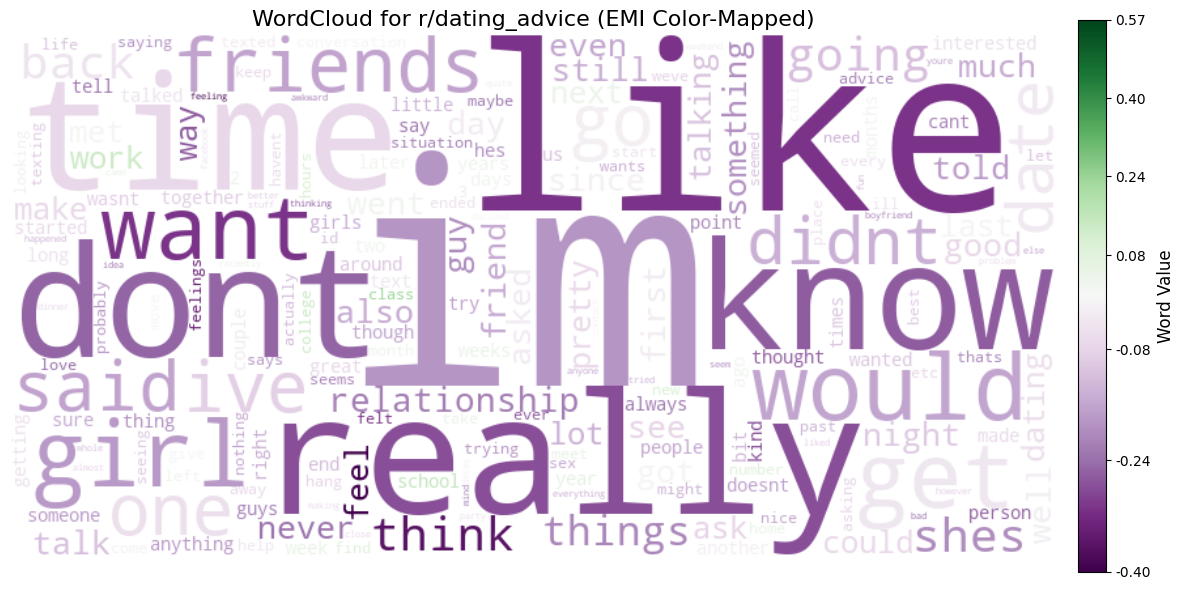

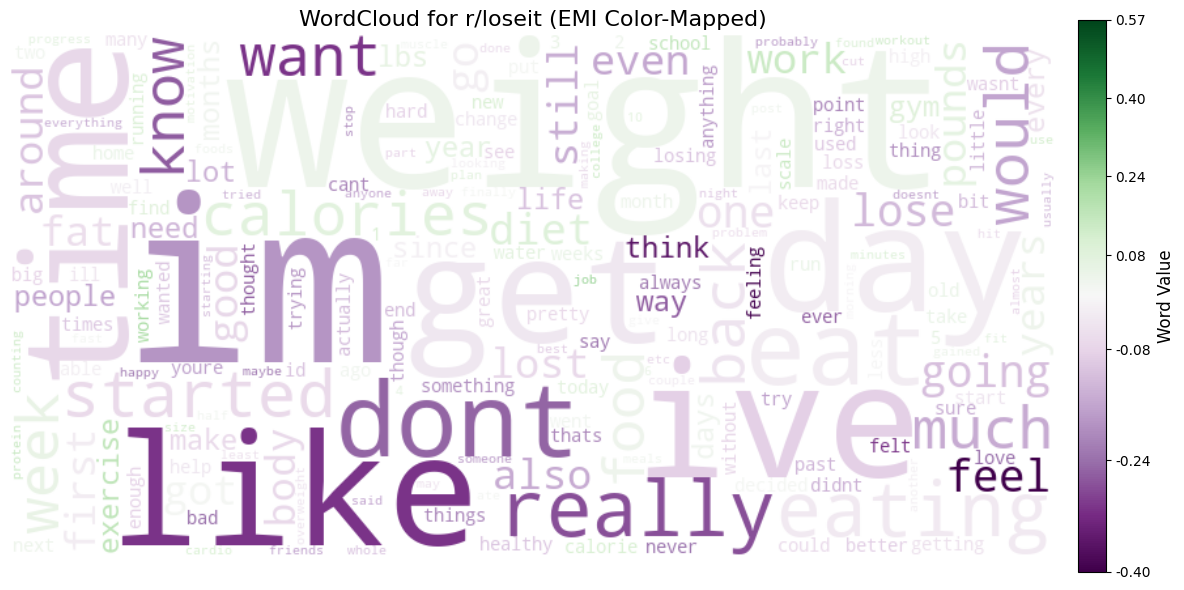

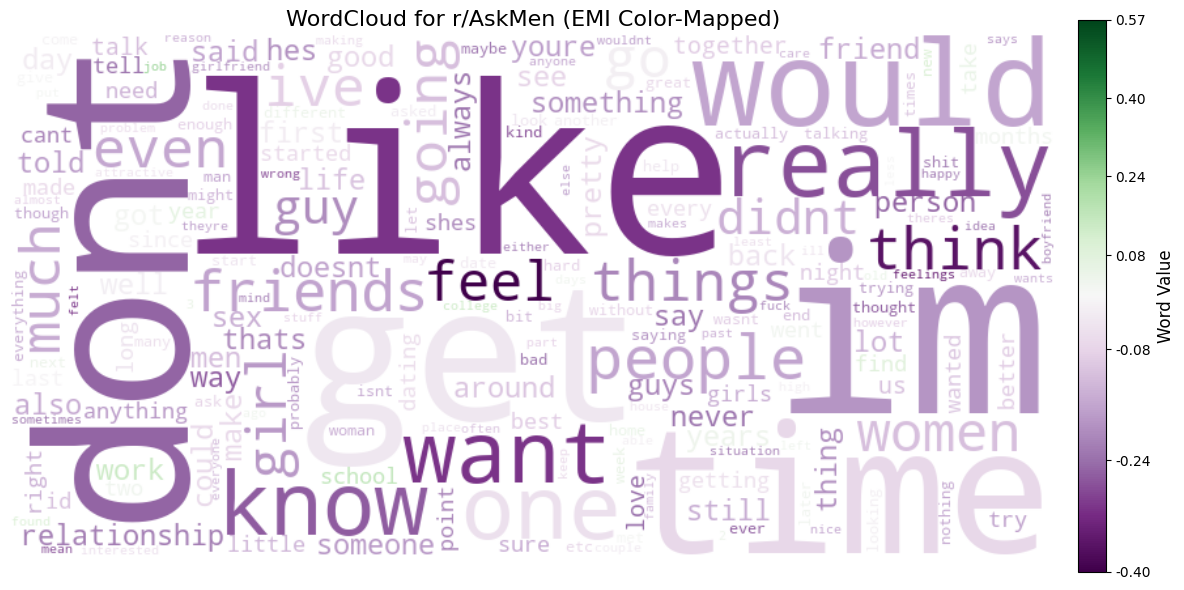

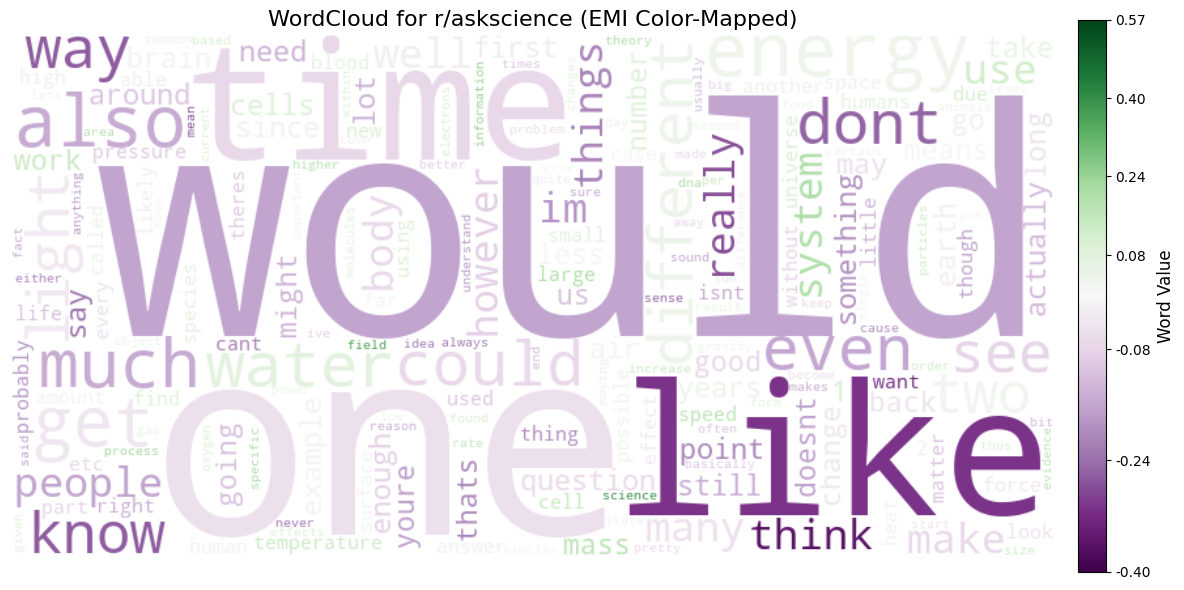

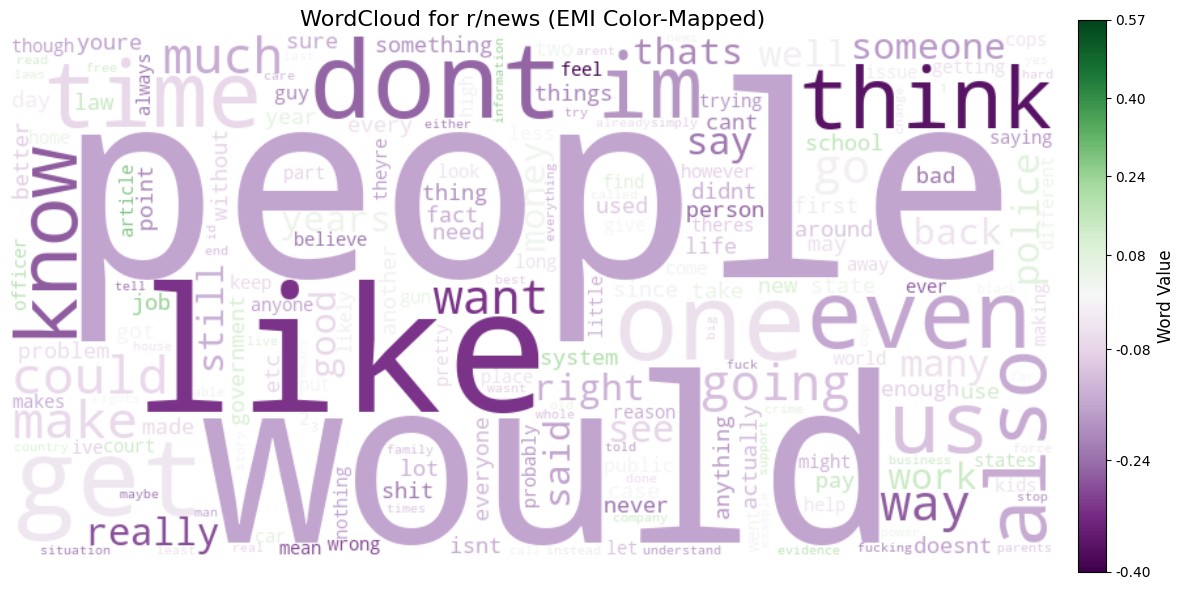

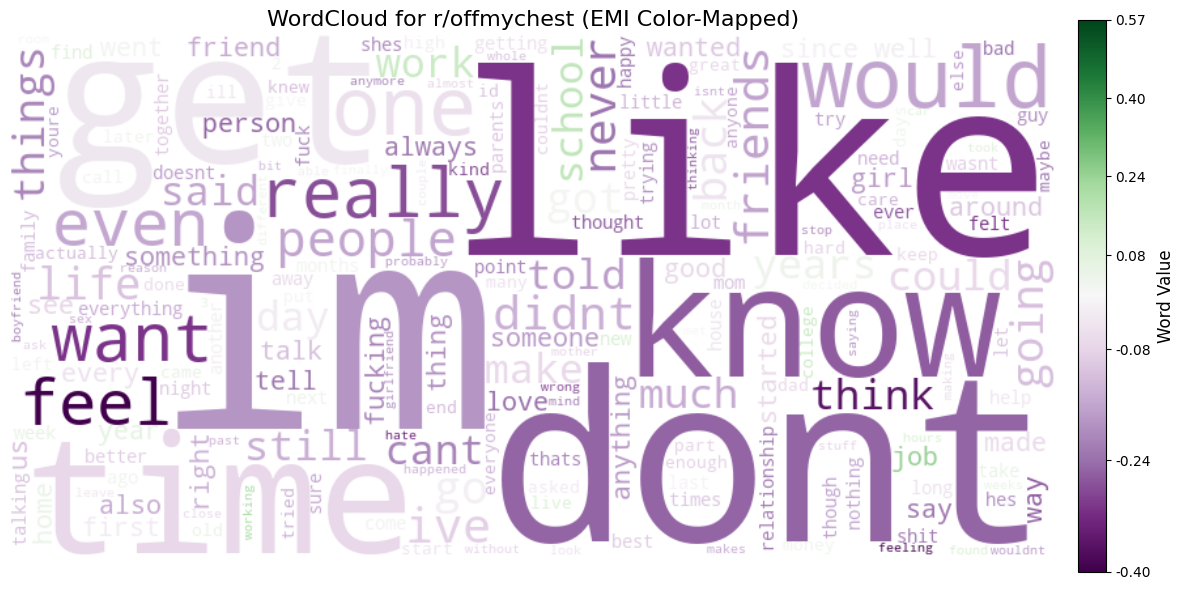

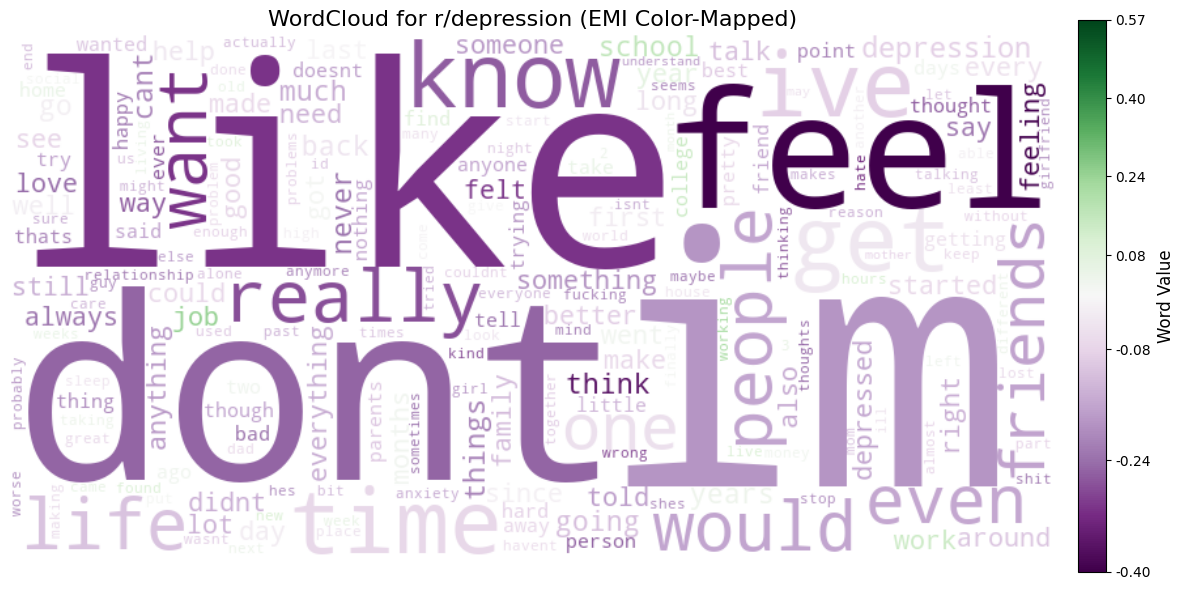

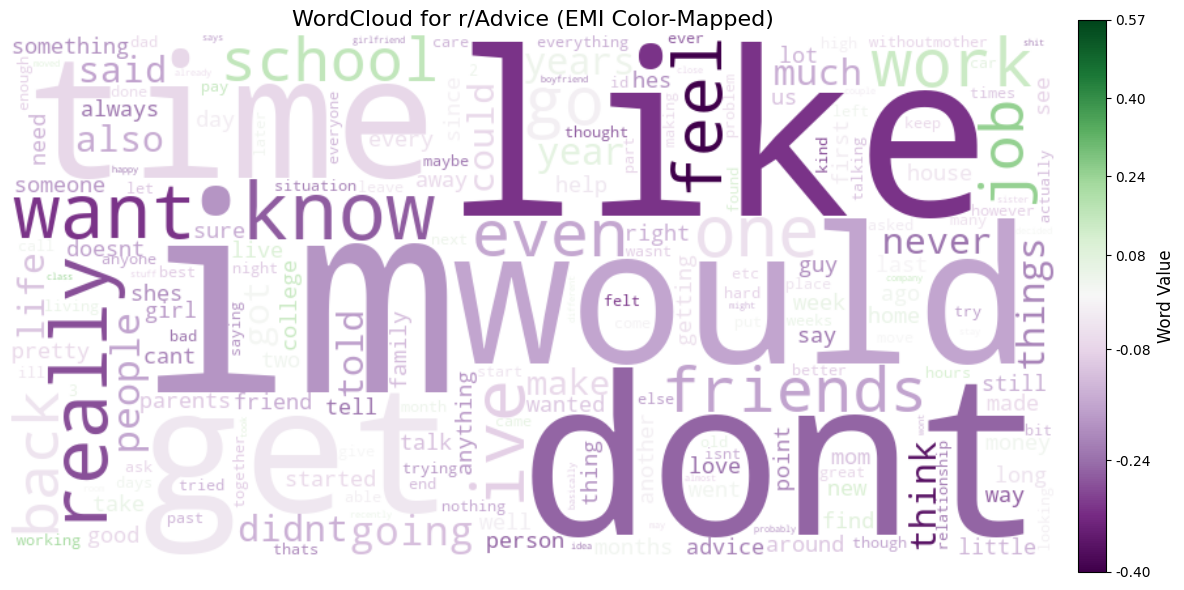

In [41]:
from matplotlib import cm
from matplotlib.colors import Normalize, TwoSlopeNorm

for reddit in subreddits: 

    df = word_stats_df[reddit]

    # 2. Create word-to-emi and word-to-frequency mappings
    word_values = dict(zip(df['word'], df['emi']))
    frequencies = dict(zip(df['word'], df['count']))

    # 3. Normalize EMI values for color mapping
    vmin = min(word_values.values())
    vmax = max(word_values.values())
    vcenter = 0

    # Use TwoSlopeNorm to keep 0 as the center
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    def colormap_func(word, font_size, position, orientation, font_path, random_state):
        value = word_values.get(word, 0)
        rgba = colormap(norm(value))  
        r, g, b, _ = [int(255 * x) for x in rgba]
        return f"rgb({r}, {g}, {b})"

    # 5. Generate and color the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    wordcloud = wordcloud.recolor(color_func=colormap_func)

    # 6. Plot it
    fig, ax = plt.subplots(figsize=(12, 6))
    img = ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"WordCloud for r/{reddit} (EMI Color-Mapped)", fontsize=16)

    # Create ScalarMappable to use with colorbar
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])  # required dummy array

    ticks = np.linspace(vmin, vmax, num=7)  # More ticks
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
    cbar.set_label("Word Value", fontsize=12)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t:.2f}" for t in ticks])


    plt.tight_layout()
    plt.show()


## top words base emi and intuition 

In [42]:
# get max and min EMI scored words
for reddit in subreddits: 

    df = word_stats_df[reddit]

    # 2. Create word-to-emi and word-to-frequency mappings
    word_values = dict(zip(df['word'], df['emi']))
    frequencies = dict(zip(df['word'], df['count']))

word_emi= pd.DataFrame(
    sorted(word_values.items(), key=lambda item: item[1]),
    columns=["word", "value"]
)

print(word_emi.head(10))
print(word_emi.tail(10))

           word     value
0          feel -0.399179
1          hurt -0.391958
2      jealousy -0.391833
3  overreacting -0.390857
4       feeling -0.387051
5     jealously -0.378603
6       jealous -0.365768
7        twinge -0.362565
8         think -0.359923
9       asshole -0.357612
                word     value
47260  documentation  0.496896
47261      forensics  0.507650
47262         coding  0.512308
47263           labs  0.515672
47264   standardized  0.515703
47265       forensic  0.520343
47266     diagnostic  0.521473
47267  certification  0.549852
47268     laboratory  0.561281
47269       research  0.565737


In [43]:
word_emi_extremes = pd.concat([word_emi.iloc[:10], word_emi.iloc[-10:]])

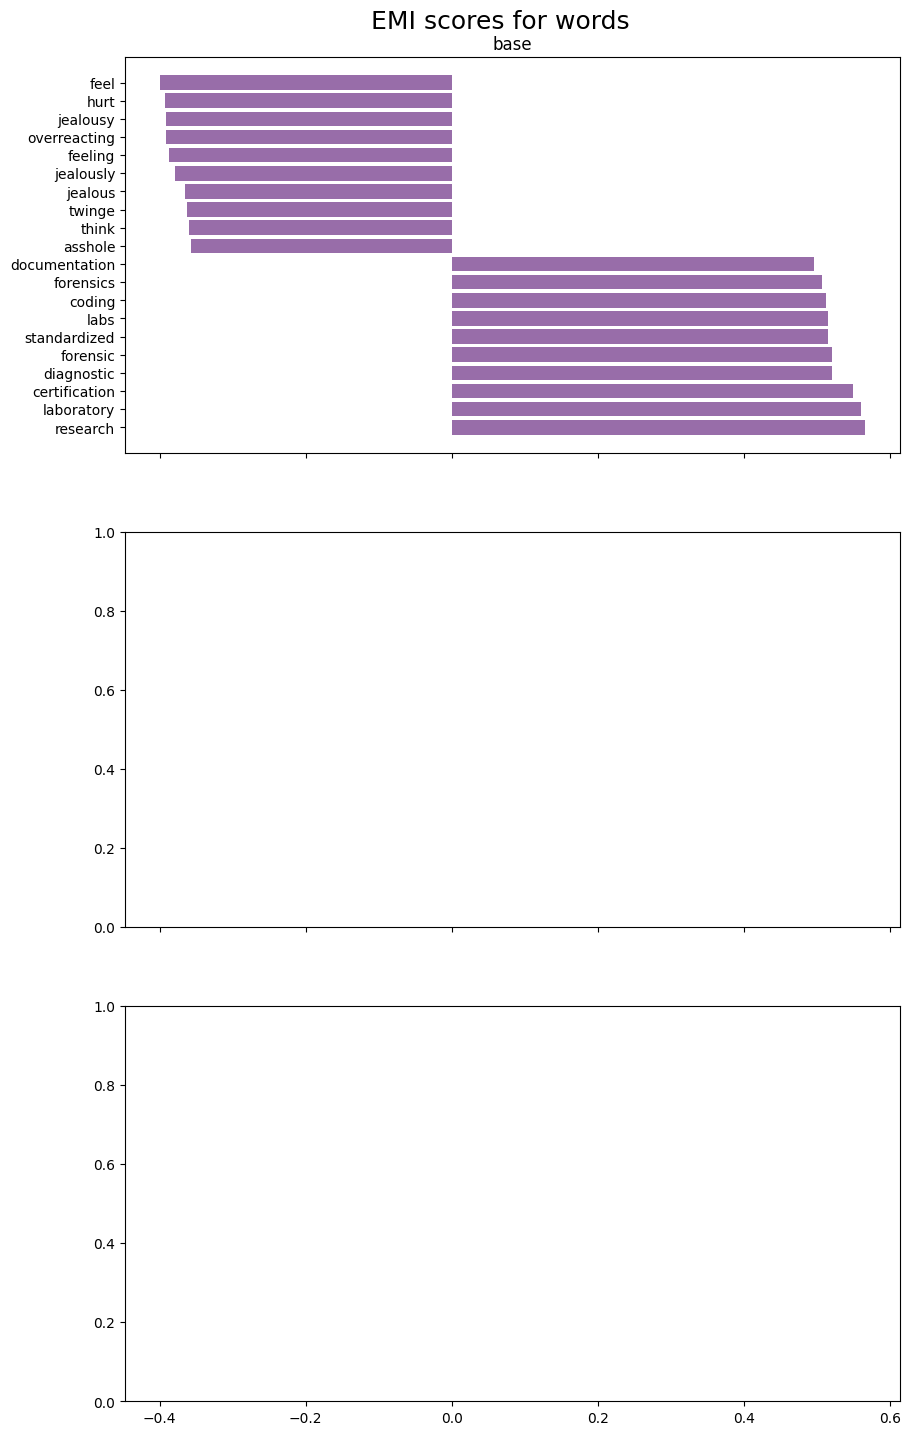

In [44]:
#
methods = ['base'] #  ,'dictionary', 'BERT'
extreme_data = [word_emi_extremes]
fig, axs = plt.subplots(3,1, figsize=(10, 16), sharex = True)
for i, (method, data) in enumerate(zip(methods, extreme_data)): 
    axs[i].barh(data['word'], data['value'], color=colormap(50))
    axs[i].invert_yaxis()  
    axs[i].set_title(method)
    fig.suptitle('EMI scores for words', fontsize = 18)
    fig.subplots_adjust(top=0.95)
plt.show()

## Subreddit vector representation

In [45]:
tldr_df

author                                               body  \
0        nervousnelli  She's been honest with you the entire time. An...   
1           rockyTron  You love yourself more than her.  That's not i...   
2       Cypriotmenace  Think of it like mailing pages of a book to di...   
3          BBQsauce18  I taught this stuff in the AF\n\nThe reason fo...   
4       ProfessorBuds  Question: I'm a Canadian and came home from un...   
...               ...                                                ...   
615387      [deleted]  Hey all,\n\nI recently started really working ...   
615388      [deleted]  After a night out I see my sleeping boyfriend’...   
615389      [deleted]  Most addictions usually illicit some kind of s...   
615390     smithethan  I (21 M ) My ex (18 F) broke up 2 months ago ....   
615391      [deleted]  So to be honest this is meant to be cathartic ...   

                                           normalizedBody  \
0       She's been honest with you the entire time. An...   
1       You love yourself more than her.  That's not i...   
2       Think of it like mailing pages of a book to di...   
3       I taught this stuff in the AF \n The reason fo...   
4       Question: I'm a Canadian and came home from un...   
...                                                   ...   
615387  Hey all, \n I recently started really working ...   
615388  After a night out I see my sleeping boyfriend’...   
615389  Most addictions usually illicit some kind of s...   
615390  I (21 M ) My ex (18 F) broke up 2 months ago ....   
615391  So to be honest this is meant to be cathartic ...   

                  subreddit subreddit_id         id  \
0       relationship_advice     t5_2r0cn    c6da92z   
1       relationship_advice     t5_2r0cn    c6dj2mm   
2         explainlikeimfive     t5_2sokd    c6dydfx   
3             todayilearned     t5_2qqjc    c6fyyak   
4                technology     t5_2qh16    c6hlkqq   
...                     ...          ...        ...   
615387               loseit     t5_2rz8w  t3_1oheej   
615388  relationship_advice     t5_2r0cn  t3_1oisu3   
615389           offmychest     t5_2ranw  t3_1oo9ew   
615390        relationships     t5_2qjvn  t3_2uwf6t   
615391        relationships     t5_2qjvn  t3_2uytxs   

                                                  content  \
0       She's been honest with you the entire time. An...   
1       You love yourself more than her.  That's not i...   
2       Think of it like mailing pages of a book to di...   
3       I taught this stuff in the AF \n The reason fo...   
4       Question: I'm a Canadian and came home from un...   
...                                                   ...   
615387  Hey all, \n I recently started really working ...   
615388  After a night out I see my sleeping boyfriend’...   
615389  Most addictions usually illicit some kind of s...   
615390  I (21 M ) My ex (18 F) broke up 2 months ago ....   
615391  So to be honest this is meant to be cathartic ...   

                                                  summary  \
0       create your own natural highs. Gym - get a phy...   
1       Stop getting back together when it doesn't wor...   
2       Always look for the highest seeded torrents, a...   
3       Always sit behind the wings, to survive. \n Bo...   
4                             Did i get scammed by Cisco?   
...                                                   ...   
615387  how do I record calories burned for walking/ev...   
615388  snooped through BF's phone, found sexy texts, ...   
615389  and forgive my grammar, and sentence structure...   
615390  so what im asking is it true that all ex girlf...   
615391  met a guy last august, friends with benefits t...   

                                                    clean  \
0       [shes, honest, entire, time, drugs, admit, lik...   
1       [love, thats, inherently, wrong, age, natural,...   
2       [think, like, mailing, pages, book, different,...  

In [46]:
subreddit_avg_vec_df = tldr_df.groupby('subreddit')['avg_vec'].apply(lambda vectors: np.mean(np.stack(vectors), axis=0)).reset_index()

In [47]:
mean_subreddit_emi_df = pd.DataFrame(tldr_df.groupby('subreddit')['emi'].mean().reset_index().rename(columns={'emi': 'mean_emi'})).sort_values('mean_emi')
subreddit_avg_vec_df=subreddit_avg_vec_df.merge(mean_subreddit_emi_df, on='subreddit')

In [48]:
from sklearn.decomposition import PCA


vecs_pca = np.stack(list(subreddit_avg_vec_df['avg_vec'].values)+ [evidence_vector, intuition_vector])

pca = PCA(n_components=2) 
avg_vec_2d = pca.fit_transform(vecs_pca)

subreddit_avg_vec_df[['pc1', 'pc2']] = avg_vec_2d[:-2]

In [49]:
subreddit_avg_vec_df

subreddit                                            avg_vec  \
0                 Advice  [0.44786832, -0.67435336, 0.46283418, -0.27042...   
1                 AskMen  [0.40420294, -0.8165006, 0.43478182, -0.243531...   
2             askscience  [0.32913518, -0.18984729, 0.14779122, -0.00735...   
3               buildapc  [0.49772558, -0.14261849, -0.046202447, -0.328...   
4          dating_advice  [0.48221424, -0.9557074, 0.3941367, -0.3063435...   
5             depression  [0.4578835, -0.8116511, 0.41288075, -0.1995011...   
6      explainlikeimfive  [0.34735736, -0.24809334, 0.20373304, -0.15494...   
7                 loseit  [0.40598637, -0.62183255, 0.260779, -0.1845864...   
8                   news  [0.34739855, -0.3177672, 0.23208627, -0.164454...   
9             offmychest  [0.4499448, -0.8065518, 0.47867954, -0.2208511...   
10   relationship_advice  [0.44839388, -0.97105354, 0.48978305, -0.30315...   
11         relationships  [0.44828686, -0.9489436, 0.49592334, -0.307439...   
12  talesfromtechsupport  [0.61056924, -0.35219637, 0.18638366, -0.13707...   
13            technology  [0.42077044, -0.28109983, 0.2013787, -0.237457...   
14         todayilearned  [0.33571067, -0.34163404, 0.21384676, -0.17503...   
15             worldnews  [0.31086606, -0.30931267, 0.13311784, -0.19712...   

    mean_emi       pc1       pc2  
0   0.339718  1.835688 -0.008718  
1  -0.330552  1.749250  0.604399  
2   1.753339 -1.666956 -1.010582  
3   1.961137 -1.370449 -2.174166  
4  -0.324222  3.021711  0.692457  
5  -0.267058  2.065143  0.650472  
6   1.327834 -1.044879 -0.907596  
7   0.502032  0.912105 -0.753621  
8   0.950472 -0.683682 -0.512859  
9  -0.167925  2.055854  0.406472  
10 -0.467262  2.889187  0.902434  
11 -0.437910  2.847138  0.827343  
12  2.287213 -0.626472 -1.593439  
13  1.550219 -1.120829 -1.120988  
14  0.845624 -0.623482 -0.590590  
15  0.882169 -0.935357 -0.397110

/var/folders/6j/zwb2vl_d44z5c7k8ddqh_b680000gn/T/ipykernel_2471/1601694458.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(evidence_pca['pc1'], evidence_pca['pc2'], c=evColor, label='evidence_reddits')
/var/folders/6j/zwb2vl_d44z5c7k8ddqh_b680000gn/T/ipykernel_2471/1601694458.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(intuition_pca['pc1'], intuition_pca['pc2'], c=intColor, label='intuitio

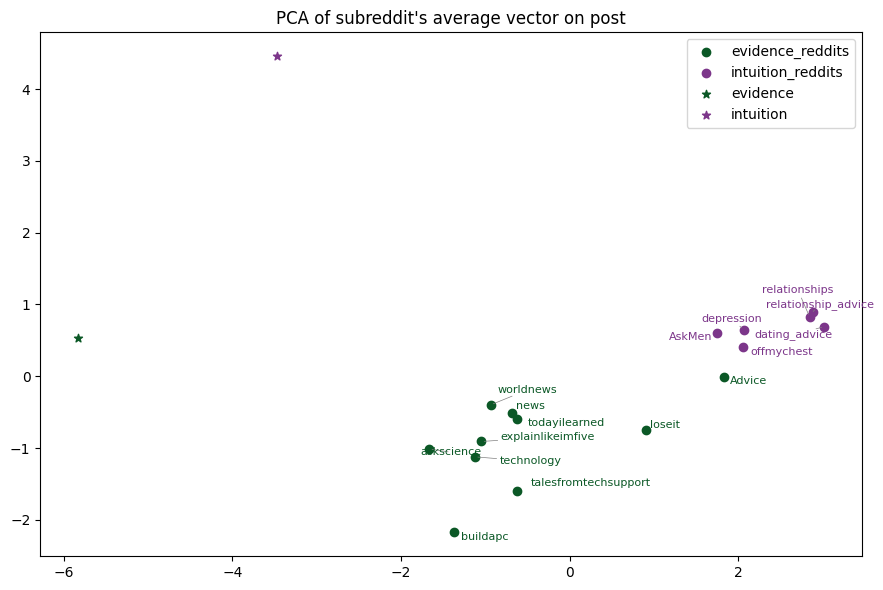

In [50]:
from adjustText import adjust_text
evidence_pca = subreddit_avg_vec_df[subreddit_avg_vec_df['mean_emi'] >= 0]
intuition_pca = subreddit_avg_vec_df[subreddit_avg_vec_df['mean_emi'] < 0]
plt.figure(figsize=(9, 6))

# Scatter points
plt.scatter(evidence_pca['pc1'], evidence_pca['pc2'], c=evColor, label='evidence_reddits')
plt.scatter(intuition_pca['pc1'], intuition_pca['pc2'], c=intColor, label='intuition_reddits')
plt.scatter(avg_vec_2d[-2:-1][0][0], avg_vec_2d[-2:-1][0][1], color=evColor, label='evidence', marker='*')
plt.scatter(avg_vec_2d[-1:][0][0], avg_vec_2d[-1:][0][1], color=intColor, label='intuition', marker='*')

# Create all label texts first
texts = []

for _, row in evidence_pca.iterrows():
    texts.append(plt.text(row['pc1'], row['pc2'], row['subreddit'], fontsize=8, color=evColor))

for _, row in intuition_pca.iterrows():
    texts.append(plt.text(row['pc1'], row['pc2'], row['subreddit'], fontsize=8, color=intColor))

# Adjust text to reduce overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
plt.title("PCA of subreddit's average vector on post")
plt.legend()
plt.tight_layout()
plt.show()

### short PCA

In [51]:
subreddit_avg_vec_df_short = tldr_df.groupby('subreddit')['avg_vec_short'].apply(lambda vectors: np.mean(np.stack(vectors), axis=0)).reset_index()
vecs_pca_short = np.stack(list(subreddit_avg_vec_df_short['avg_vec_short'].values)+ [evidence_vector, intuition_vector])

pca = PCA(n_components=2) 
avg_vec_2d_short = pca.fit_transform(vecs_pca_short)

subreddit_avg_vec_df_short[['pc1', 'pc2']] = avg_vec_2d_short[:-2]

# add mean emi for coloring 
mean_emi_per_subreddit_short = tldr_df.groupby('subreddit')['emi_short'].mean()

# Join the mean EMI to the main dataframe on subreddit
subreddit_avg_vec_df_short = subreddit_avg_vec_df_short.join(mean_emi_per_subreddit_short, on='subreddit')
subreddit_avg_vec_df_short = subreddit_avg_vec_df_short.rename(columns={'emi_short': 'mean_emi_short'})

/var/folders/6j/zwb2vl_d44z5c7k8ddqh_b680000gn/T/ipykernel_2471/4179983540.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(evidence_pca['pc1'], evidence_pca['pc2'], c=evColor, label='evidence_reddits')
/var/folders/6j/zwb2vl_d44z5c7k8ddqh_b680000gn/T/ipykernel_2471/4179983540.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(intuition_pca['pc1'], intuition_pca['pc2'], c=intColor, label='intuitio

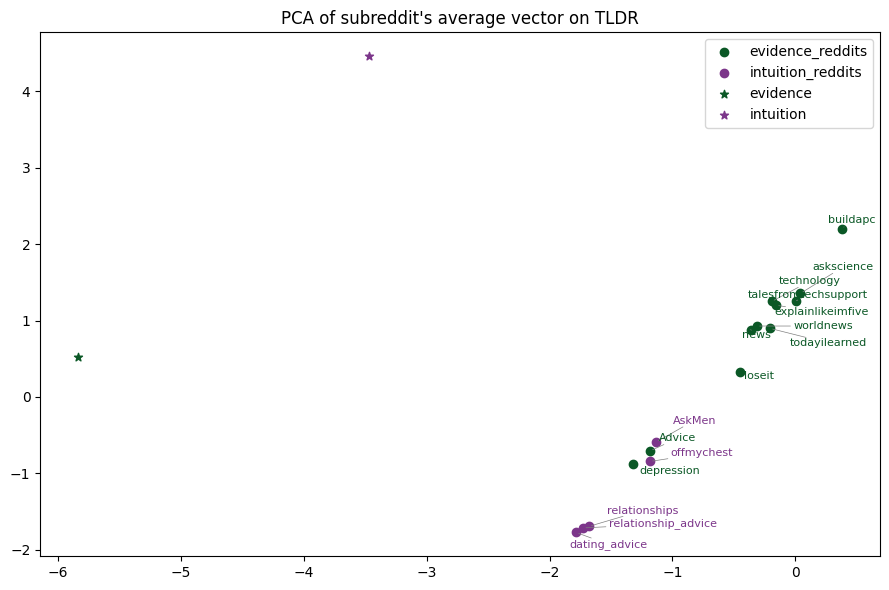

In [52]:
from adjustText import adjust_text
evidence_pca = subreddit_avg_vec_df_short[subreddit_avg_vec_df_short['mean_emi_short'] >= 0]
intuition_pca = subreddit_avg_vec_df_short[subreddit_avg_vec_df_short['mean_emi_short'] < 0]
plt.figure(figsize=(9, 6))

# Scatter points
plt.scatter(evidence_pca['pc1'], evidence_pca['pc2'], c=evColor, label='evidence_reddits')
plt.scatter(intuition_pca['pc1'], intuition_pca['pc2'], c=intColor, label='intuition_reddits')
plt.scatter(avg_vec_2d[-2:-1][0][0], avg_vec_2d[-2:-1][0][1], color=evColor, label='evidence', marker='*')
plt.scatter(avg_vec_2d[-1:][0][0], avg_vec_2d[-1:][0][1], color=intColor, label='intuition', marker='*')

# Create all label texts first
texts = []

for _, row in evidence_pca.iterrows():
    texts.append(plt.text(row['pc1'], row['pc2'], row['subreddit'], fontsize=8, color=evColor))

for _, row in intuition_pca.iterrows():
    texts.append(plt.text(row['pc1'], row['pc2'], row['subreddit'], fontsize=8, color=intColor))

# Adjust text to reduce overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
plt.title("PCA of subreddit's average vector on TLDR")
plt.legend()
plt.tight_layout()
plt.show()